Collaborators: Anton Korikov (1008704270), Alexis Bruneau (1008704270), Ramy ElMallah (1009480303)

In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.model_selection import KFold
import torch
import torch.nn as nn

In [ ]:
#upload a3digits.zip and data.py
uploaded = files.upload()

Saving a3digits.zip to a3digits (1).zip
Saving data.py to data (1).py


In [ ]:
import data
train_data, train_labels, test_data, test_labels = data.load_all_data_from_zip('a3digits.zip', 'data')

#Q4.0)


In [ ]:
def plot_means(train_data, train_labels):
    means = []
    for i in range(0, 10):
        i_digits = data.get_digits_by_label(train_data, train_labels, i)

        #compute mean
        i_digits_mean = i_digits.mean(axis=0).reshape((8,8))
        means.append(i_digits_mean)

    # Plot all means on same axis
    all_concat = np.concatenate(means, 1)
    plt.imshow(all_concat, cmap='gray')
    plt.show()

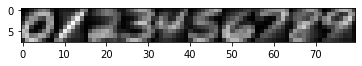

In [ ]:
plot_means(train_data,train_labels)


#Q4.1)

In [ ]:
'''
Question 4.1 Skeleton Code

Here you should implement and evaluate the k-NN classifier.
'''
class KNearestNeighbor(object):
    '''
    K Nearest Neighbor classifier
    '''

    def __init__(self, train_data, train_labels):
        self.train_data = train_data
        self.train_norm = (self.train_data**2).sum(axis=1).reshape(-1,1)
        self.train_labels = train_labels

    def l2_distance(self, test_point):
        '''
        Compute L2 distance between test point and each training point
        
        Input: test_point is a 1d numpy array
        Output: dist is a numpy array containing the distances between the test point and each training point
        '''
        # Process test point shape
        test_point = np.squeeze(test_point)
        if test_point.ndim == 1:
            test_point = test_point.reshape(1, -1)
        assert test_point.shape[1] == self.train_data.shape[1]

        # Compute squared distance
        test_norm = (test_point**2).sum(axis=1).reshape(1,-1)
        dist = self.train_norm + test_norm - 2*self.train_data.dot(test_point.transpose())
        return np.squeeze(dist)

    def query_knn(self, test_point, k):
        '''
        Query a single test point using the k-NN algorithm

        You should return the digit label provided by the algorithm
        '''
        
        #get list of distances from test point to each training point: [d0,d1,...,dn]
        dist = self.l2_distance(test_point)
        
        #dist to a list of tuples [(d,ind),...], i.e. [(d_0,0),(d_1,1),...]
        labeled_dist = [(dist[i],i) for i in range(len(dist))]
        
        #sort by distance
        labeled_dist.sort(key=lambda x: x[0])

        #get labels of nearest k points
        k_near_labels = []
        for i in range(k):
          #get k_th nearest point index
          pt = labeled_dist[i][1]
          #append label
          k_near_labels.append(self.train_labels[pt])

        #find mode of nearest labels
        #NOTE: scipy.stats.mode() breaks ties by choosing the smallest of the tied values
        digit = mode(k_near_labels).mode[0]
        return digit

    def predict(self, data):
      #make predictions for k = 1
      #this function will be used in part 3
      k = 1
      n = len(data)
      res = np.empty(n)
      for i in range(n):
        res[i] = self.query_knn(data[i],k)

      return res



def classification_accuracy(knn, k, eval_data, eval_labels):
    '''
    Evaluate the classification accuracy of knn on the given 'eval_data'
    using the labels
    '''

    #classif_res[i] = 1 if classifaction of point i is correct, 0 otherwise
    classif_res = []

    for i in range(len(eval_data)):
      pred = knn.query_knn(eval_data[i],k)
      if pred == eval_labels[i]:
        classif_res.append(1)
      else:
        classif_res.append(0)

    #get accuracy
    acc = sum(classif_res)/len(classif_res)
    return acc



##Example usage:
#knn = KNearestNeighbor(train_data, train_labels)
#predicted_label = knn.query_knn(test_data[5], 10)

In [ ]:
knn = KNearestNeighbor(train_data, train_labels)

#4.1.1 a) and b)

In [ ]:
#get accuracy for train and test data at k = 1 and k = 15
train_acc_1 = classification_accuracy(knn,1,train_data,train_labels)
train_acc_15 = classification_accuracy(knn,15,train_data,train_labels)
test_acc_1 = classification_accuracy(knn,1,test_data,test_labels)
test_acc_15 = classification_accuracy(knn,15,test_data,test_labels)

In [ ]:
#print("K = 1: Train Accuracy = %f" %(train_acc_1))
print(f" K = 1: Train Accuracy: {train_acc_1:f}, Test Accuracy: {test_acc_1:f}\n \
K = 15: Train Accuracy: {train_acc_15:f}, Test Accuracy: {test_acc_15:f}")

 K = 1: Train Accuracy: 1.000000, Test Accuracy: 0.968750
 K = 15: Train Accuracy: 0.959429, Test Accuracy: 0.958500


#4.1.2

**Tie-breaking is done by scipy.stats.mode() by selecting the smallest of the tied values**.

#4.1.3

In [ ]:
def cross_validation(train_data, train_labels, k_range=np.arange(1,16),n_folds = 10):
    '''
    Perform 10-fold cross validation to find the best value for k

    Note: Previously this function took knn as an argument instead of train_data,train_labels.
    The intention was for students to take the training data from the knn object - this should be clearer
    from the new function signature.
    '''

    #get 10 folds
    kf = KFold(n_splits=n_folds)
    splits = kf.split(train_data)

    #acc[i][j] will be accuracy of i'th fold, j'th value of k.
    acc = []

    for train_inds, val_inds in splits:

          X_train, X_val = train_data[train_inds], train_data[val_inds]
          y_train, y_val = train_labels[train_inds], train_labels[val_inds]

          #get knn classifier for fold
          knn = KNearestNeighbor(X_train, y_train)

          #fold_acc[j] = acc[i][j], i.e., accuracy of i'th fold, j'th k.
          fold_acc = []

          for k in k_range:
              k_acc = classification_accuracy(knn,k,X_val,y_val)
              fold_acc.append(k_acc)

          acc.append(fold_acc)
        
    #average accuracies accross folds
    acc = np.asarray(acc)
    avg_acc = np.average(acc,axis=0)

    return avg_acc

In [ ]:
#get average validation accuracy accross all folds for each value of k
acc = cross_validation(train_data, train_labels)

In [ ]:
k_vals = np.arange(1,16)

for i in range(len(acc)):
  print(f"At k = {k_vals[i]}: Validation Accuracy = {acc[i]}")

At k = 1: Validation Accuracy = 0.9644285714285715
At k = 2: Validation Accuracy = 0.9575714285714285
At k = 3: Validation Accuracy = 0.9634285714285715
At k = 4: Validation Accuracy = 0.961
At k = 5: Validation Accuracy = 0.9608571428571429
At k = 6: Validation Accuracy = 0.959
At k = 7: Validation Accuracy = 0.957857142857143
At k = 8: Validation Accuracy = 0.9574285714285715
At k = 9: Validation Accuracy = 0.9555714285714286
At k = 10: Validation Accuracy = 0.9528571428571428
At k = 11: Validation Accuracy = 0.9522857142857143
At k = 12: Validation Accuracy = 0.9514285714285714
At k = 13: Validation Accuracy = 0.9504285714285714
At k = 14: Validation Accuracy = 0.95
At k = 15: Validation Accuracy = 0.9485714285714287


###Chosing best k:
-----
The highest validation accuracy averaged accross folds occurs at k = 1, with

Validation Accuraccy (@k=1) =  0.964429

By definition, training accuracy at k = 1 is 100% (since the query point is always classified as its correct class because it is its own nearest neighbor).

Test accuracy for k = 1 was obtained in part 4.1.1 (by calling: classification_accuracy(knn,1,test_data,test_labels)):

Test Accuracy (@k=1) = 0.968750

In [ ]:

#to do: we have validation accuracy for selected k, but get train accuracy (calculate at same time as validation accuraccy) and test_accuracy

## 4.2.1 MLP - Neural Network Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
train_data.shape

(7000, 64)

In [ ]:
'''
Tried gridsearch but was taking long 
clf_gridsearch = MLPClassifier(max_iter=300,random_state=0)

param_grid_MLP = {
    'hidden_layer_sizes': [(40,20,10),(10,)],
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
'''
MLP_classifier = MLPClassifier(
    hidden_layer_sizes=(64,20,10), # Number of pixel 64 and output 10 classes
    max_iter=250,
    activation = 'logistic',
    alpha=1e-4,
    solver="sgd",
    verbose=10,
    random_state=0,
    learning_rate_init=0.1,
)

MLP_classifier.fit(train_data,train_labels)


Iteration 1, loss = 2.31634274
Iteration 2, loss = 2.30664020
Iteration 3, loss = 2.30497162
Iteration 4, loss = 2.30650161
Iteration 5, loss = 2.30608542
Iteration 6, loss = 2.30471208
Iteration 7, loss = 2.30361883
Iteration 8, loss = 2.30402146
Iteration 9, loss = 2.30168931
Iteration 10, loss = 2.29866348
Iteration 11, loss = 2.29421902
Iteration 12, loss = 2.27790285
Iteration 13, loss = 2.21000166
Iteration 14, loss = 1.97223225
Iteration 15, loss = 1.76326354
Iteration 16, loss = 1.68122660
Iteration 17, loss = 1.63175300
Iteration 18, loss = 1.59213112
Iteration 19, loss = 1.55394783
Iteration 20, loss = 1.52112131
Iteration 21, loss = 1.48443692
Iteration 22, loss = 1.44764728
Iteration 23, loss = 1.40670307
Iteration 24, loss = 1.36377872
Iteration 25, loss = 1.32184382
Iteration 26, loss = 1.26409964
Iteration 27, loss = 1.19207856
Iteration 28, loss = 1.09568880
Iteration 29, loss = 0.98894993
Iteration 30, loss = 0.88189296
Iteration 31, loss = 0.78815331
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(activation='logistic', hidden_layer_sizes=(64, 20, 10),
              learning_rate_init=0.1, max_iter=250, random_state=0,
              solver='sgd', verbose=10)

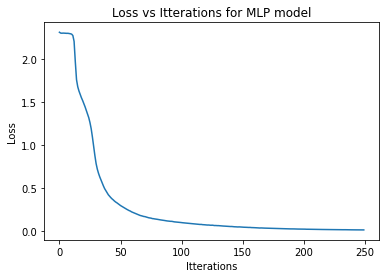

In [ ]:
# Plot Loss Curve

plt.plot(MLP_classifier.loss_curve_)
plt.xlabel("Itterations")
plt.ylabel("Loss")
plt.title("Loss vs Itterations for MLP model")
plt.show()

In [ ]:
print(f" The accuracy score is: {MLP_classifier.score(test_data, test_labels)}")

 The accuracy score is: 0.963


## 4.2.2 SVM Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
# Defining parameter range for gridsearch
param_grid = {'C': [0.1, 1, 10],
              'gamma': [1 , 0.1, 0.01],
              'kernel': ['linear','poly','sigmoid','rbf']
              }

svm_model = GridSearchCV(SVC(),param_grid,cv=5)
svm_model.fit(train_data,train_labels)
y_pred = svm_model.predict(test_data)
svm_model.score(test_data, test_labels)


0.979

In [ ]:
print(svm_model.best_estimator_)

SVC(C=10, gamma=0.1)


## 4.2.3 AdaBoost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
param_grid = {'base_estimator__max_depth': [1, 2],
              'learning_rate': [0.1 , 1],
              'n_estimators': [64, 1024],
              }

In [ ]:
ada_grid_model = GridSearchCV(AdaBoostClassifier(algorithm='SAMME.R', base_estimator=DecisionTreeClassifier(criterion='entropy', splitter='best'), random_state=1),param_grid, verbose=3, cv=2)
ada_grid_model.fit(train_data,train_labels)
ada_grid_model.score(test_data, test_labels)


Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END base_estimator__max_depth=1, learning_rate=0.1, n_estimators=64;, score=0.762 total time=   1.4s
[CV 2/2] END base_estimator__max_depth=1, learning_rate=0.1, n_estimators=64;, score=0.756 total time=   1.3s
[CV 1/2] END base_estimator__max_depth=1, learning_rate=0.1, n_estimators=1024;, score=0.753 total time=  20.4s
[CV 2/2] END base_estimator__max_depth=1, learning_rate=0.1, n_estimators=1024;, score=0.811 total time=  20.3s
[CV 1/2] END base_estimator__max_depth=1, learning_rate=1, n_estimators=64;, score=0.696 total time=   1.3s
[CV 2/2] END base_estimator__max_depth=1, learning_rate=1, n_estimators=64;, score=0.777 total time=   1.3s
[CV 1/2] END base_estimator__max_depth=1, learning_rate=1, n_estimators=1024;, score=0.692 total time=  20.1s
[CV 2/2] END base_estimator__max_depth=1, learning_rate=1, n_estimators=1024;, score=0.658 total time=  20.0s
[CV 1/2] END base_estimator__max_depth=2, learning_rate=0.1,

0.9005

In [ ]:
# The following code doesn't have hyperparameter tuning (uses chosen hyperparameters)
# It allows re-running the code without going through tuning again
def get_adaboost_model(max_depth=2, learning_rate=1, n_estimators=1024):
  dtc = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, splitter='best')
  return AdaBoostClassifier(algorithm='SAMME.R',
            base_estimator=dtc,
            learning_rate=learning_rate, n_estimators=n_estimators, random_state=1)

ada_model = get_adaboost_model()
ada_model.fit(train_data, train_labels)
ada_model.score(test_data, test_labels)

0.9005

# 4.3

## 4.3.1 ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc

def show_roc_curve(model, data, labels, model_name):
  unique_classes = set(labels)
  preds = model.predict(data)

  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  all_new_labels, all_new_preds = [], []
  for per_class in unique_classes:
      #creating a list of all the classes except the current class 
      other_class = [x for x in unique_classes if x != per_class]

      #marking the current class as 1 and all other classes as 0
      new_labels = [0 if x in other_class else 1 for x in labels]
      new_preds = [0 if x in other_class else 1 for x in preds]
      assert len(new_labels) == len(new_preds)
      all_new_labels.extend(new_labels)
      all_new_preds.extend(new_preds)
      fpr[per_class], tpr[per_class], _ = roc_curve(new_labels, new_preds)
      roc_auc[per_class] = auc(fpr[per_class], tpr[per_class])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(all_new_labels, all_new_preds)
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  all_fpr = np.unique(np.concatenate([fpr[i] for i in unique_classes]))
  mean_tpr = np.zeros_like(all_fpr)
  for i in unique_classes:
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= len(unique_classes)

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  for i in unique_classes:
      plt.plot(
          fpr[i],
          tpr[i],
          lw=2,
          label=f"class {int(i)} (area = {roc_auc[i]:0.2f})",
      )

  plt.plot([0, 1], [0, 1], "k--", lw=2)
  plt.plot(
      fpr["micro"],
      tpr["micro"],
      label=f"micro-average (area = {roc_auc['micro']:0.2f})",
      linestyle=":",
      linewidth=4,
  )
  plt.plot(
      fpr["macro"],
      tpr["macro"],
      label=f"macro-average (area = {roc_auc['macro']:0.2f})",
      linestyle=":",
      linewidth=4,
  )
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(f"ROC Curve for {model_name} model")
  plt.legend(loc="lower right")
  plt.show()

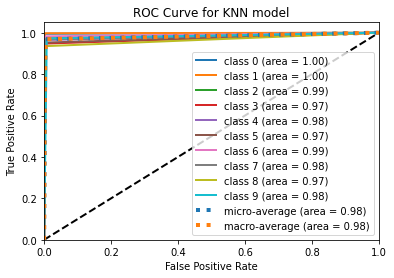

In [ ]:
show_roc_curve(knn, test_data, test_labels, "KNN")

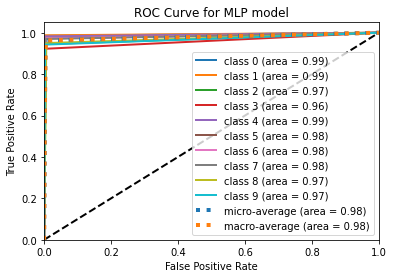

In [ ]:
show_roc_curve(MLP_classifier, test_data, test_labels, "MLP")

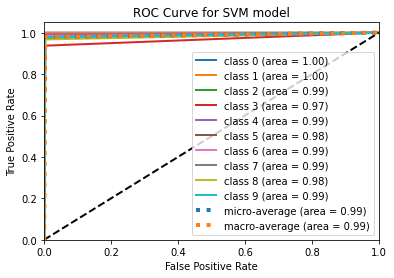

In [ ]:
show_roc_curve(svm_model, test_data, test_labels, "SVM")

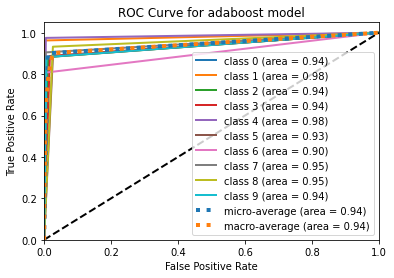

In [ ]:
show_roc_curve(ada_model, test_data, test_labels, "adaboost")

## 4.3.2 Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

def show_confusion_matrix(model, data, labels, model_name):
  preds = model.predict(data)
  cm = confusion_matrix(labels, preds)
  plt.figure()
  sn.heatmap(cm, annot=True,fmt='g')
  plt.title(f"Confusion Matrix for {model_name} model")
  plt.show()

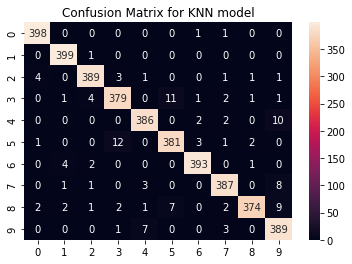

In [ ]:
show_confusion_matrix(knn, test_data, test_labels, "KNN")

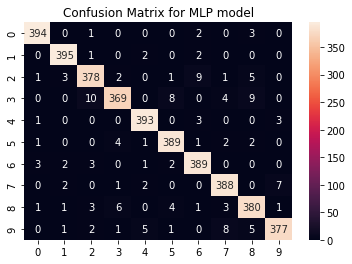

In [ ]:
show_confusion_matrix(MLP_classifier, test_data, test_labels, "MLP")

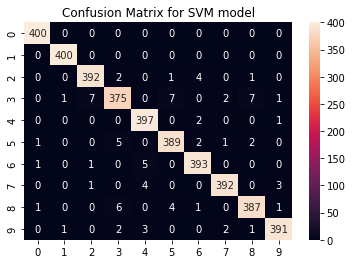

In [ ]:
show_confusion_matrix(svm_model, test_data, test_labels, "SVM")

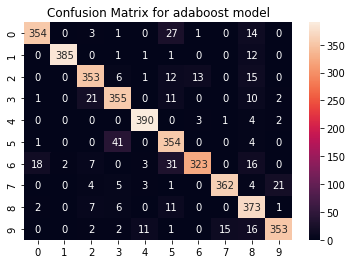

In [ ]:
show_confusion_matrix(ada_model, test_data, test_labels, "adaboost")

## 4.3.3-5 Accuracy, Precision, Recall

In [ ]:
from tabulate import tabulate
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
data = [[1, 'Liquid', 24, 12],
[2, 'Virtus.pro', 19, 14],
[3, 'PSG.LGD', 15, 19],
[4,'Team Secret', 10, 20]]

def compare_accuracy_precision_recall(models, data, labels, model_names):
  accuracy_list, precision_list_micro, precision_list_macro, recall_list_micro, recall_list_macro = [], [], [], [], []
  for model in models:
    preds = model.predict(data)
    accuracy_list.append(accuracy_score(labels, preds))
    precision_list_micro.append(precision_score(labels, preds, average='micro'))
    precision_list_macro.append(precision_score(labels, preds, average='macro'))
    recall_list_micro.append(recall_score(labels, preds, average='micro'))
    recall_list_macro.append(recall_score(labels, preds, average='macro'))
  data = [model_names, accuracy_list, precision_list_micro, precision_list_macro, recall_list_micro, recall_list_macro]
  data_t = pd.DataFrame(data).T.values.tolist()
  print(tabulate(data_t, headers=["Model", "Accuracy", "Precision (Micro)", "Precision (Macro)", "Recall (Micro)", "Recall (Macro)"]))

In [ ]:
compare_accuracy_precision_recall([knn, MLP_classifier, svm_model, ada_model], test_data, test_labels, ["KNN", "MLP", "SVM", "adaboost"])

Model        Accuracy    Precision (Micro)    Precision (Macro)    Recall (Micro)    Recall (Macro)
---------  ----------  -------------------  -------------------  ----------------  ----------------
KNN           0.96875              0.96875             0.96897            0.96875           0.96875
MLP           0.963                0.963               0.963041           0.963             0.963
SVM           0.979                0.979               0.978968           0.979             0.979
adaboost2     0.9005               0.9005              0.905485           0.9005            0.9005
